In [38]:
# Import TensorFlow and other necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Import for predictions
import math
import os
from os import listdir

# Supressing warning messages on output
import warnings
warnings.filterwarnings("ignore")

In [39]:
# SELECT THE TYPE OF MODEL TRAINING HERE, COMMENT OUT OTHER

config_human_nonhuman = {
    "dataset_path": "data/training_human_nonhuman/",
    "model_save_path": "model/trained_human_nonhuman",
    "prediction_data_path": "data/predictions/human_nonhuman/",
    "epochs": 15,
    "batch_size": 64,
    "img_height": 120,
    "img_width": 128
}

config_mask_nomask = {
    "dataset_path": "data/training_mask_nomask/",
    "model_save_path": "model/trained_mask_nomask",
    "prediction_data_path": "data/predictions/mask_nomask/",
    "epochs": 15,
    "batch_size": 64,
    "img_height": 120,
    "img_width": 128
}

config = config_human_nonhuman
# config = config_mask_nomask

In [40]:
# Image Loader Params
dataset_url = config["dataset_path"]
batch_size  = config["batch_size"]
img_height  = config["img_height"]
img_width   = config["img_width"]

data_dir = pathlib.Path(dataset_url)

# Train Split at 70%
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size)

# Validation of the data at 70%
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size)


Found 49780 files belonging to 2 classes.
Using 34846 files for training.
Found 49780 files belonging to 2 classes.
Using 14934 files for validation.


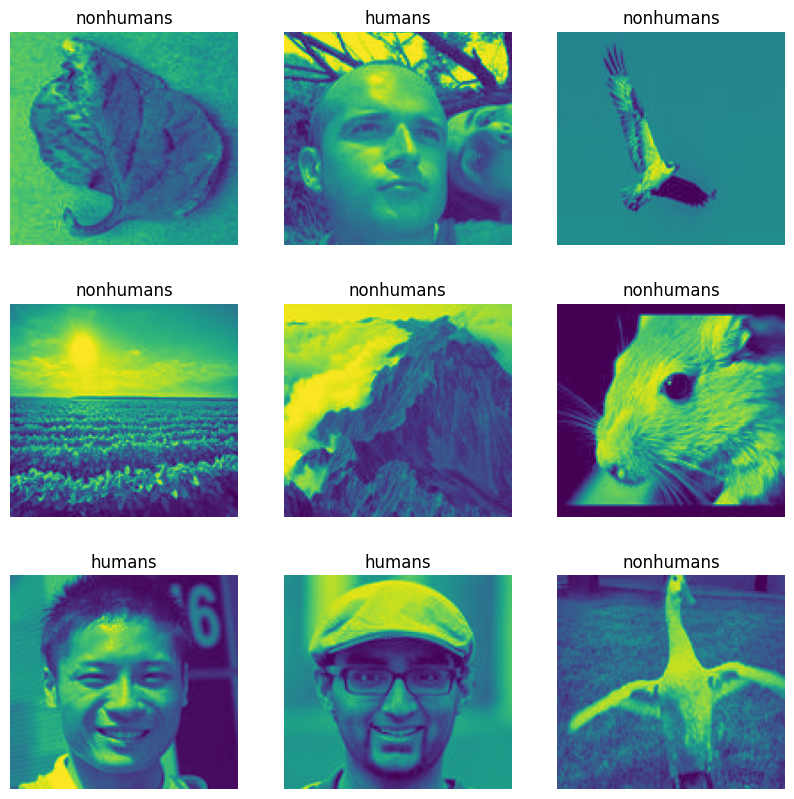

In [41]:
# Classification of names - each image type in its own dir
class_names = train_ds.class_names

# Visualize the images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [42]:
AUTOTUNE = tf.data.AUTOTUNE
SHAPE_SIZE = 1

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(
  1./255, input_shape=(img_height, img_width, SHAPE_SIZE)
)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
# Note Shape of Train image
print(first_image.shape)

0.0 1.0
(120, 128, 1)


In [43]:
# Create basic Keras Model

# The Keras Sequential model consists of three convolution blocks(tf.keras.layers.Conv2D)
# with a max pooling layer(tf.keras.layers.MaxPooling2D) in each of them.
#
# There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that
# is activated by a ReLU activation function ('relu').
#
# This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

num_classes = len(class_names)
model_save_path = config["model_save_path"]
epochs = config["epochs"]

try:
    model = keras.models.load_model(model_save_path)
    history = model.history
except OSError:
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, SHAPE_SIZE)),
        layers.Conv2D(16, SHAPE_SIZE, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, SHAPE_SIZE, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, SHAPE_SIZE, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

    # Compile the model

    # For this tutorial, choose the tf.keras.optimizers.Adam optimizer and
    # tf.keras.losses.SparseCategoricalCrossentropy loss function.
    #
    # To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

    model.save(model_save_path)

In [44]:
# Show the Model Summary - need to look into what this means
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 120, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 120, 128, 16)      32        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 64, 32)        544       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 32, 64)       

In [45]:
# Visualize the Training Results in Plot Forms
def visualization_report(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

try:
  visualization_report(history, epochs)
except AttributeError as err:
  print(err)


'NoneType' object has no attribute 'history'


human1.jpg
1/1 [==============================] - 0s 87ms/step
human1.jpg most likely belongs to humans with a 100.00 percent confidence.
human2.png
1/1 [==============================] - 0s 18ms/step
human2.png most likely belongs to humans with a 100.00 percent confidence.
nh1.jpeg
1/1 [==============================] - 0s 18ms/step
nh1.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh2.jpeg
1/1 [==============================] - 0s 16ms/step
nh2.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh5.png
1/1 [==============================] - 0s 16ms/step
nh5.png most likely belongs to nonhumans with a 100.00 percent confidence.
human4.jpeg
1/1 [==============================] - 0s 15ms/step
human4.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh3.jpeg
1/1 [==============================] - 0s 15ms/step
nh3.jpeg most likely belongs to nonhumans with a 100.00 percent confidence.
nh4.jpeg
1/1 [=====================

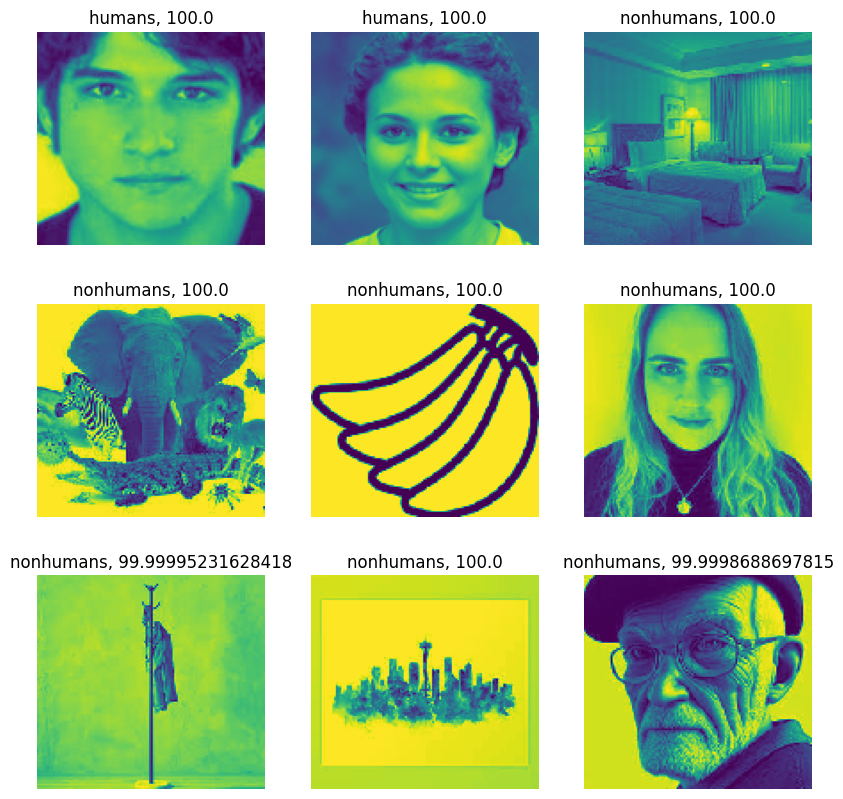

In [46]:
# Running Predictions on Images outside of Dataset in General

pred_path = config["prediction_data_path"]
plt.figure(figsize=(10, 10))
figure_counter = 1

for img_p in os.listdir(pred_path):
    if (img_p.endswith(".png")) or (img_p.endswith(".jpg")) or (img_p.endswith(".jpeg")):
        print(img_p)
        # Grayscale the image in the same way for prediction
        img_path = f'{pred_path}{img_p}'
        img = tf.keras.utils.load_img(
            img_path, color_mode='grayscale', target_size=(img_height, img_width), keep_aspect_ratio=True
        )
        
        ax = plt.subplot(3, 3, figure_counter)
        plt.imshow(img)
        plt.axis("off")

        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result_msg = f'{class_names[np.argmax(score)]}, {100 * np.max(score)}'
        plt.title(result_msg)
        print(
            "{} most likely belongs to {} with a {:.2f} percent confidence."
            .format(img_p, class_names[np.argmax(score)], 100 * np.max(score))
        )

        figure_counter += 1
